<a href="https://colab.research.google.com/github/KhoomeiK/MindMapResearch/blob/master/HAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DATA PREP STUFF

In [0]:
# download dataset and labels
! pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded2 = drive.CreateFile({'id': '1WYdQ6xeZ8GaZZftXTnbtzEOP0LvWnG3W'}) 
downloaded2.GetContentFile('labels.pkl')

downloaded = drive.CreateFile({'id': '1BqSv5mgxsyP5rhMoAAKFyvPtAH8XLcO6'}) 
downloaded.GetContentFile('embeddings.zip')

! unzip embeddings.zip

In [0]:
# read dataset into memory
from os import listdir
from os.path import isfile, join
import pandas as pd

mypath = 'cse198f_shiv'
csvs = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print(len(csvs))

data = []
names = []
for csv in csvs:
    if csv[-4:] == '.csv':
        try:
            data.append(pd.read_csv(join(mypath, csv), encoding='CP1252'))
            names.append(csv[:-4])
        except:
            try:
                data.append(pd.read_csv(join(mypath, csv), encoding='UTF8'))
                names.append(csv[:-4])
            except:
                continue
print(len(data))

# pd.reset_option('all')
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)

In [0]:
# # download embedding tools
# ! ls *
# ! mkdir fastText
# ! curl https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip > fastText/crawl-300d-2M.vec.zip
# ! unzip fastText/crawl-300d-2M.vec.zip -d fastText/
# ! mkdir encoder
# ! curl -Lo encoder/infersent2.pkl https://dl.fbaipublicfiles.com/infersent/infersent2.pkl
# ! curl https://raw.githubusercontent.com/facebookresearch/InferSent/master/models.py > models.py
# ! mkdir embeddings

In [0]:
# generate embeddings of dataset
import torch, os
import numpy as np
import tensorflow_hub as hub

from absl import logging
from models import InferSent

import pickle
import time

MODEL_PATH = 'encoder/infersent2.pkl'
W2V_PATH = 'fastText/crawl-300d-2M.vec'

def load_infersent_model(model_path=MODEL_PATH, word_embeddings_path=W2V_PATH):
	params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048, 'pool_type': 'max', 'dpout_model': 0.0, 'version': 2}
	infersent = InferSent(params_model).cuda()
	infersent.load_state_dict(torch.load(model_path))
	infersent.set_w2v_path(word_embeddings_path)
	infersent.build_vocab_k_words(K=100000)
	return infersent

def get_infersent_vectors(sentences, model):
	return model.encode(sentences, tokenize=False, verbose=False)

def get_user_data_embeddings(comments, model):
	# model = load_infersent_model()
	embedding = get_infersent_vectors(comments, model)
	return embedding

dataEmbeddings = []
model = load_infersent_model()

start = time.time()
for i, name in enumerate(names):
	comments = list(data[i]['text']) if 'text' in data[i] else []
	if len(comments) >= 1:
		print(i, name)
		try:
			embeddings = get_user_data_embeddings(data[i]['text'], model)
			print(len(embeddings), 'comments')
			dataEmbeddings.append(embeddings)
			with open('embeddings/%s.pkl' % name, 'wb') as pkl:
				pickle.dump(embeddings, pkl)
		except:
			print('ERROR')

print(time.time() - start)

## MODEL RUN

In [3]:
# load labels and user embeddings and create Users data obj
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from csv import reader
import pickle
from os import listdir
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Users(Dataset):
    def __init__(self, embedPath, labelPath, split): 
        self.users, self.labels = [], []
        users = {}
        labels = pickle.load(open(labelPath, 'rb')) # { username: [ depressionPercent, vaderScore ] }
        fileList = listdir(embedPath)

        if type(split) == float:
            userList = random.sample(fileList, int(len(fileList) * split))
            for user in userList: # must download and unzip embeddings.zip first
                users[user[:-4]] = pickle.load(open('%s/%s' % (embedPath, user), 'rb'))
            self.usernames = users.keys()
    
        elif type(split) == Users:
            for user in fileList:
                if user[:-4] not in split.usernames:
                    users[user[:-4]] = pickle.load(open('%s/%s' % (embedPath, user), 'rb'))
        
        intersection = list(set(users.keys()).intersection(set(labels.keys())))
        for i in intersection:
            userTensor = torch.tensor([users[i]])
            if list(userTensor.shape)[1] != 1: # exclude single comment users
                self.users.append(userTensor)
                self.labels.append(torch.tensor([labels[i]]))

        print(len(self), self[0])

    def __getitem__(self, i):
        return self.users[i], self.labels[i] # remove [0]
    
    def __len__(self):
        assert len(self.users) == len(self.labels)
        return len(self.users)

# def my_collate(batch):
#     data = [item[0] for item in batch]
#     target = [item[1] for item in batch]
#     target = torch.Tensor(target)
#     return [data, target]

train = Users('user_subset', 'labels.pkl', 0.8)
test = Users('user_subset', 'labels.pkl', train)
dataloader_params = {'shuffle': True}
# dataloader_params = {'batch_size': 4, 'shuffle': True, 'collate_fn': my_collate}
# train, test = DataLoader(train, **dataloader_params), DataLoader(test, **dataloader_params)

4283 (tensor([[[ 0.0075, -0.0305,  0.0211,  ..., -0.0712, -0.0425, -0.0419],
         [ 0.0075,  0.0172,  0.0182,  ...,  0.0570, -0.0313,  0.0316],
         [ 0.0075,  0.0785, -0.0169,  ...,  0.0286, -0.0207, -0.0089],
         ...,
         [ 0.0075, -0.0349,  0.0532,  ...,  0.0260,  0.0789,  0.0068],
         [ 0.0075, -0.0679,  0.0344,  ..., -0.0303, -0.0051, -0.0049],
         [ 0.0075,  0.0095,  0.0598,  ...,  0.0493,  0.0140,  0.0096]]]), tensor([ 2.9258e+00, -2.6232e-06]))
1073 (tensor([[[ 0.0075,  0.0108,  0.1532,  ...,  0.1020,  0.0197, -0.0015],
         [ 0.0075,  0.0294,  0.0614,  ...,  0.0334,  0.0144,  0.0117],
         [ 0.0075,  0.1654,  0.0547,  ...,  0.0074,  0.0391, -0.0292],
         ...,
         [ 0.0075,  0.1244,  0.1437,  ...,  0.0627,  0.0317,  0.0030],
         [ 0.0075,  0.0269,  0.0773,  ...,  0.0355,  0.0313,  0.0272],
         [ 0.0075, -0.0335,  0.0611,  ...,  0.0192, -0.0057,  0.0158]]]), tensor([3.0937e+00, 5.7340e-06]))


In [0]:
def matrix_mul(input, weight, bias=False):
    feature_list = []
    _input = input.squeeze(0)
    for feature in _input:
        feature = feature.unsqueeze(1).reshape(1, 300)
        feature = torch.mm(feature, weight)
        if isinstance(bias, torch.nn.parameter.Parameter):
            feature = feature + bias.expand(feature.size()[0], bias.size()[1])
        feature = torch.tanh(feature)#.unsqueeze(0) ?
        feature_list.append(feature)

    return torch.cat(feature_list, 0)#.squeeze(1) ?

def element_wise_mul(input1, input2):
    _input1 = input1.squeeze(0)
    feature_list = []
    for feature_1, feature_2 in zip(_input1, input2):
        feature = feature_1 * feature_2
        feature_list.append(feature.unsqueeze(0))

    output = torch.cat(feature_list, 0)
    return torch.sum(output, 0).unsqueeze(0)

class AN(nn.Module):
    def __init__(
        self,
        batch_size=4,
        embedding_dimension=4096, # from glove to infersent?
        hidden_size=150, 
        n_layers=1, # multiple?
    ):
        super(AN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.batch_size = batch_size

        self.sent_weight = nn.Parameter(torch.randn(2 * hidden_size, 2 * hidden_size))
        self.sent_bias = nn.Parameter(torch.randn(1, 2 * hidden_size))
        self.context_weight = nn.Parameter(torch.randn(2 * hidden_size, 1))

        self.gru = nn.GRU(embedding_dimension, hidden_size, bidirectional=True)
        self.fc = nn.Linear(2 * hidden_size, 1) 
        self._create_weights(mean=0.005)

    def _create_weights(self, mean=0.0, std=0.01):
        self.sent_weight.data.normal_(mean, std)
        self.sent_bias.data.normal_(mean, std)
        self.context_weight.data.normal_(mean, std)

    def forward(self, user):
        f_output, h_output = self.gru(user)
        output = matrix_mul(f_output, self.sent_weight, self.sent_bias)
        output = matrix_mul(output, self.context_weight)#.permute(1, 0) ?
        output = F.softmax(output)
        output = element_wise_mul(f_output, output).squeeze(0) # '''output.permute(1, 0) ?'''
        output = self.fc(output)
        output = F.leaky_relu(output)

        return output #, h_output

class Simple(nn.Module):
    def __init__(
        self,
        batch_size=4,
        embedding_dimension=4096,
        hidden_size=150, 
    ):
        super(Simple, self).__init__()
        self.batch_size = batch_size
        self.hidden_size = hidden_size

        self.gru = nn.GRU(embedding_dimension, hidden_size, bidirectional=True)
        self.fc = nn.Linear(2 * hidden_size, 1) 

    def forward(self, user):
        f_output, h_output = self.gru(user)
        output = f_output[0][-1]
        output = self.fc(output)
        output = F.leaky_relu(output)

        return output #, h_output

In [12]:
model = Simple().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()
epochs = 10
model.train()

train_losses = []
for epoch in range(epochs):
    total = 0
    losses = []
    for X, Y in train:
        # loss = 0
        # X, Y = [x.unsqueeze(0).to(device) for x in X], [y.to(device) for y in Y]
        # for x, y in zip(X, Y):
        #     pred = model(x)
        #     # print(pred, y)
        #     if loss == 0:
        #         loss = criterion(pred, y)
        #     else:
        #         loss += criterion(pred, y)
        # loss /= 4
        X, Y = X.to(device), Y[0].to(device)
        pred = model(X)
        loss = criterion(pred, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        total += 1

        if total % 300 == 0:
            print(pred.item(), Y.item(), loss.item())
    
    epoch_loss = sum(losses) / total
    print(epoch, epoch_loss)
    train_losses.append(epoch_loss)

print(train_losses)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2.8068816661834717 3.0999999046325684 0.08591829985380173
3.3222899436950684 3.0999999046325684 0.049412861466407776
3.2013018131256104 3.090054988861084 0.012375855818390846
2.99052095413208 3.0719640254974365 0.0066329739056527615
2.9123282432556152 2.9069581031799316 2.8838403522968292e-05
3.145559072494507 3.0999999046325684 0.0020756376907229424
3.001337766647339 2.9319372177124023 0.00481643620878458
3.1665351390838623 2.9213993549346924 0.06009155139327049
3.0893356800079346 3.0712947845458984 0.00032547389855608344
2.916375160217285 3.0999999046325684 0.0337180458009243
2.9672510623931885 3.076308012008667 0.011893418617546558
2.967952251434326 2.8958919048309326 0.005192693322896957
2.8488476276397705 2.941307783126831 0.008548879995942116
3.131556987762451 3.07671856880188 0.003007252234965563
0 0.17648650353057424
2.982814073562622 3.0999999046325684 0.013732519000768661
2.9112727642059326 3.0999999046325684 0.03561793267726898
3.092107057571411 3.090054988861084 4.210985935

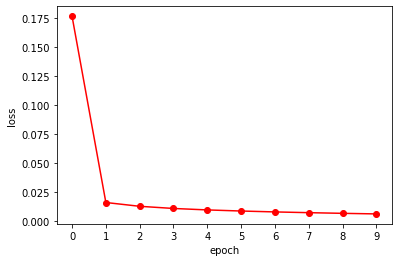

In [18]:
from matplotlib import pyplot as plt

plt.xticks(range(len(train_losses)))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_losses, '-ro')

# torch.save(model.state_dict(), 'model_save.pkl')
# upload = drive.CreateFile({'title': 'model_save_5-2-20.pkl'})
# upload.SetContentFile('model_save.pkl')
# upload.Upload()

In [20]:
torch.no_grad()
total = 0
losses = []

for X, Y in test:
    # X, Y = [x.unsqueeze(0).to(device) for x in X], [y.to(device) for y in Y]
    # for x, y in zip(X, Y):
    #     pred = model(x)
    #     loss = criterion(pred, y)
        
    #     # print('pred', pred.item())
    #     # print('targ', y.item())
    #     # print('loss', loss.item())
        
    #     total += 1
    #     losses.append(loss.item())

    X, Y = X.to(device), Y[0].to(device)
    pred = model(X)
    loss = criterion(pred, Y)

    losses.append(loss.item() if loss.item() < 1 else 0)
    total += 1
    
    # if total % 20 == 0:
    if loss.item() > 0.1:
        print(pred.item(), Y.item(), loss.item())

test_loss = sum(losses) / total
print(test_loss)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


3.1883997917175293 2.789320230484009 0.1592644900083542
3.328064441680908 2.9328255653381348 0.15621377527713776
3.212629795074463 2.7979981899261475 0.17191936075687408
3.251276731491089 2.895514965057373 0.12656643986701965
3.144162893295288 2.8232040405273438 0.10301458835601807
3.0630102157592773 2.714539051055908 0.12143215537071228
3.2029030323028564 2.8370885848999023 0.13382020592689514
3.282413959503174 2.917086601257324 0.13346408307552338
0.012858712153788532
